In [2]:
import torchvision
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
import numpy as np
from torch.optim import lr_scheduler
import time
from sklearn.preprocessing import StandardScaler

In [3]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/MLDM project

/content/drive/MyDrive/MLDM project


In [5]:
n_epochs = 3
batch_size_train = 1024
batch_size_test = 1024
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [6]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [7]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

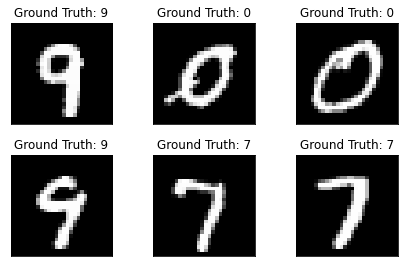

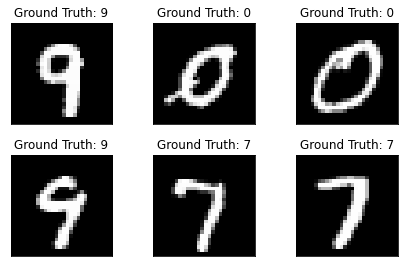

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [36]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            nn.Linear(32*7*7, 10),)
    def forward(self, x):
        x = self.conv1(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1) 
        output = self.out(x)
        return output, x    # return x for clustering

In [90]:
net = Net()

In [21]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':60000,
    'val':10000
}

In [91]:
criterion_class = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.002)

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [92]:
net = net.to(device)

In [93]:
pca = IncrementalPCA(n_components=1024, batch_size=512, whiten=True)
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=512, max_iter=1000, init_size=3*100)

In [94]:
def train_model(model, criterion_class, optimizer, num_epochs=25, c=1000):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = 5
    first_time = True
    # флаг для определения первого батча


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = []
            train_acc = []
            val_acc = []
            cluster_acc = []

            batch_num = 0
            # Iterate over data.
            for inputs, class_labels in dataloaders[phase]:

                inputs = inputs.to(device)
                class_labels = class_labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):
              
                    class_out, vectors = model(inputs)
                    _, preds = torch.max(class_out, 1)
                    vectors = vectors.to(cpu)
                    vectors_np = vectors.detach().numpy()
                    vectors_np = StandardScaler().fit_transform(vectors_np)
                    cluster_labels = None

                    # кластеризация только на первом батче
                    if first_time:
                      cluster_labels = kmeans.fit_predict(vectors_np)
                      first_time = False
                    else:
                      cluster_labels = kmeans.predict(vectors_np)

                    
                    clust_sam = cluster_labels.copy()
                    cluster_labels = torch.from_numpy(cluster_labels).long().to(device)
                    loss = criterion_class(class_out,cluster_labels)
                    
                    if (phase == 'train'):
                        loss.backward()
                        optimizer.step()
                        cluster = True

                    class_labels_clone = class_labels.clone().to(cpu).detach().numpy()
                    preds_clone = preds.clone().to(cpu).detach().numpy()

                    my_score = normalized_mutual_info_score(class_labels_clone,preds_clone )
                    cluster_acc.append(normalized_mutual_info_score(class_labels_clone,clust_sam))



                running_loss += loss.item() * inputs.size(0)
                running_corrects.append(normalized_mutual_info_score(class_labels_clone,preds_clone ))


            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = np.mean(running_corrects)
            plt.plot(running_corrects)
            plt.xlabel(f'number of batch fro phase {phase}')
            plt.grid(True)
            plt.show()
            print(f'{phase} Loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} cluster_acc: {np.mean(cluster_acc)}')

            if phase == 'val' and epoch_loss < best_epoch_loss:
                best_epoch_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())





    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best : {:4f}'.format( best_epoch_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './models/model')
    return model

Epoch 0/3
----------


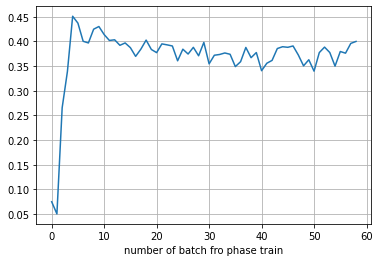

train Loss: 0.4472 acc: 0.3698 cluster_acc: 0.3656431710288564


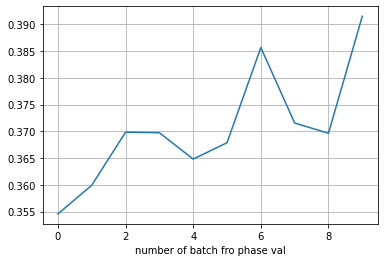

val Loss: 0.1783 acc: 0.3705 cluster_acc: 0.36080378256027
Epoch 1/3
----------


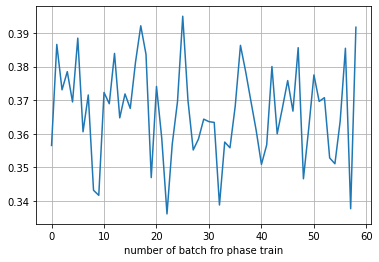

train Loss: 0.1694 acc: 0.3667 cluster_acc: 0.36173148398947524


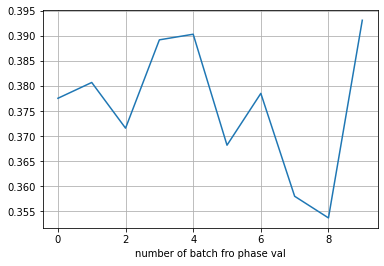

val Loss: 0.1474 acc: 0.3761 cluster_acc: 0.36451380698990976
Epoch 2/3
----------


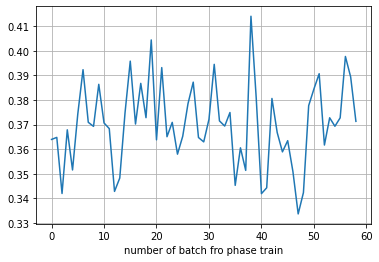

train Loss: 0.1665 acc: 0.3700 cluster_acc: 0.36656207823817666


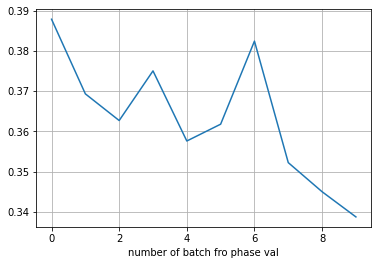

val Loss: 0.1500 acc: 0.3633 cluster_acc: 0.37069096216588115
Epoch 3/3
----------


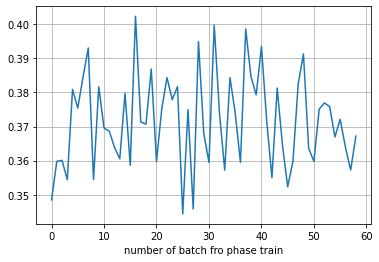

train Loss: 0.1368 acc: 0.3718 cluster_acc: 0.3687631538071469


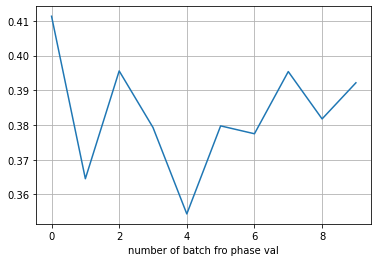

val Loss: 0.1332 acc: 0.3832 cluster_acc: 0.3734580723027392
Training complete in 3m 16s
Best : 0.133171


In [95]:
model_ft_tf = train_model(net, criterion_class, optimizer_ft, num_epochs=4)

The problem of the method described above is that we initialized the clustering model only one time, so witch means, that we have limited traning space

To solve this problem, let's drop the fully connected layers and reinitialize them and retrain clustering model every 10 batches . 

In [96]:
def train_reconstructor(model, criterion, optimizer, epoch, lr):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 5
  best_acc = 0.0
  mni_scores = []
  new_layer = nn.Sequential(
            nn.Linear(32*7*7, 20),
            nn.Sigmoid(),
            nn.Linear(20, 10))
  kmean = MiniBatchKMeans(n_clusters=10, batch_size=512, max_iter=1000, init_size=3*100)
  need_new_cluster = True
  psevdo_labels = None

  criterion_in = criterion
  optimizer_in = optimizer.Adam(model.parameters(), lr=lr)


  for i in range(epoch):

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0
      running_corrects = 0
      batch_num = 1

      for inputs, labels in dataloaders[phase]:
        optimizer_in.zero_grad()
        



        if  batch_num % 10 == 0 and phase == 'train':

          model.out = new_layer
          model = model.to(device)
          criterion_in = criterion
          optimizer_in = optimizer.Adam(model.parameters(), lr=lr)
          model.train()
          print('new model')




        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          probs, vectors = model(inputs)
          vectors_cp = vectors.clone().to(cpu).detach().numpy()
          vectors_cp = StandardScaler().fit_transform(vectors_cp)
          _, preds = torch.max(probs, 1)



          if need_new_cluster:
            psevdo_labels = kmean.fit_predict(vectors_cp)
            need_new_cluster = False
          else:
            psevdo_labels = kmean.predict(vectors_cp)
          
          labels_cp = labels.clone().to(cpu).detach().numpy()

          preds_cp = preds.clone().to(cpu).detach().numpy()
          nmi_score = normalized_mutual_info_score(labels_cp ,preds_cp)
          mni_scores.append(nmi_score)
          if batch_num % 10 == 0:
            plt.plot(mni_scores)
            plt.xlabel(f'number of batch fro phase {phase}')
            plt.grid(True)
            plt.title('changes of MNI score for each 10 batches')
            plt.show()
            mni_scores = []
          # print(nmi_score)


         

          psevdo_labels_gpu = torch.from_numpy(psevdo_labels).long().to(device)



          loss = criterion_in(probs,psevdo_labels_gpu)



          if (phase == 'train'):
              loss.backward()
              optimizer_in.step()

        running_loss += loss*inputs.size(0)
        running_corrects += nmi_score*inputs.size(0)
        batch_num += 1

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model

In [97]:
criterion = nn.CrossEntropyLoss()
optimizer = optim
net_drop = Net()
net_drop.to(device)

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

new model


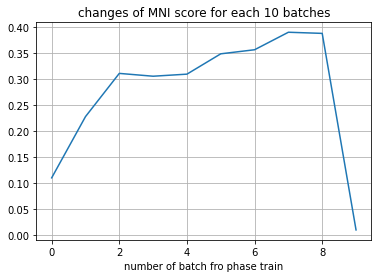

new model


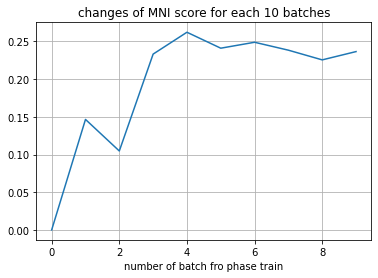

new model


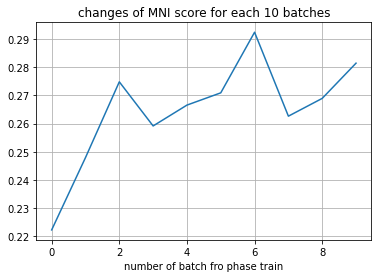

new model


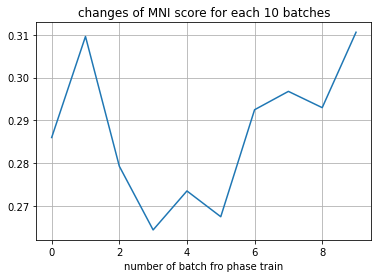

new model


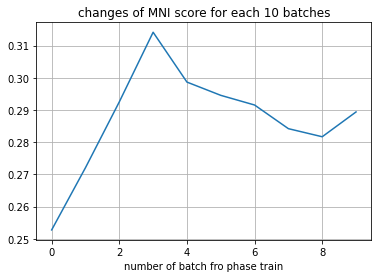

train Loss: 1.5783 Acc: 0.2678


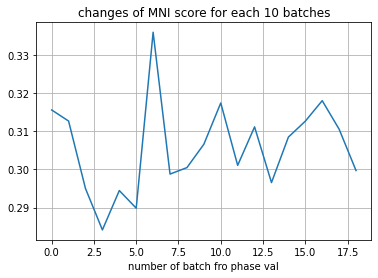

val Loss: 1.2128 Acc: 0.3084
new model


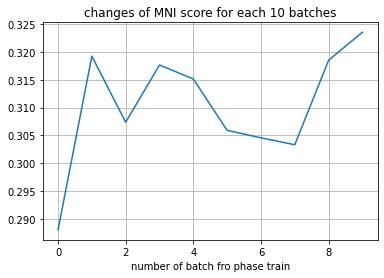

new model


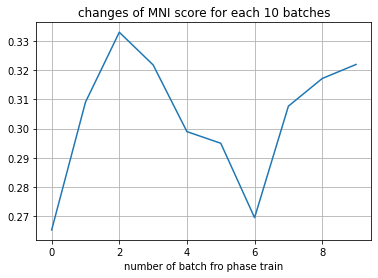

new model


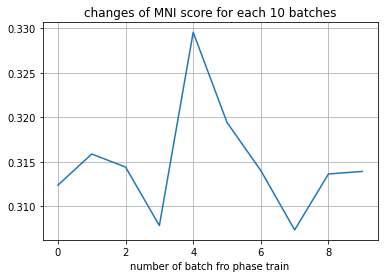

new model


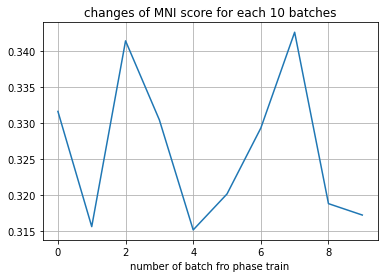

new model


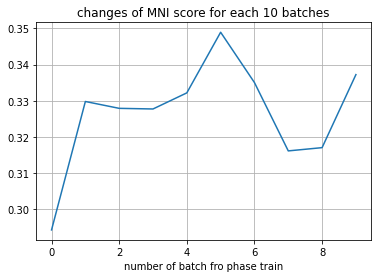

train Loss: 0.9785 Acc: 0.3180


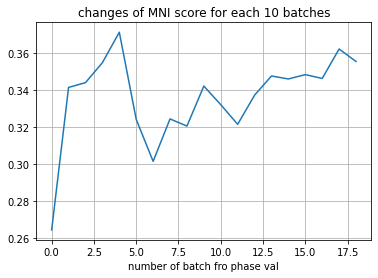

val Loss: 0.7705 Acc: 0.3435
new model


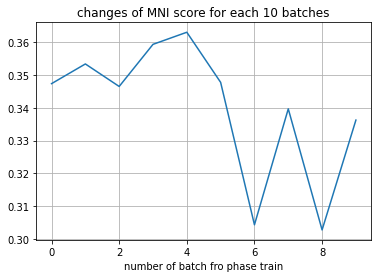

new model


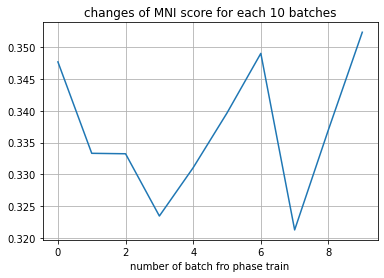

new model


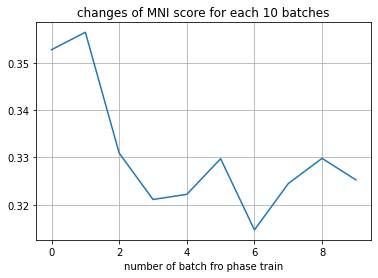

new model


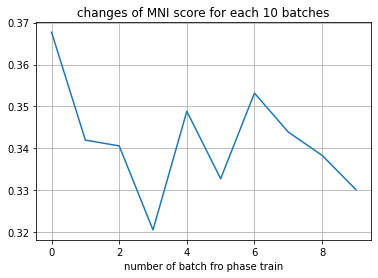

new model


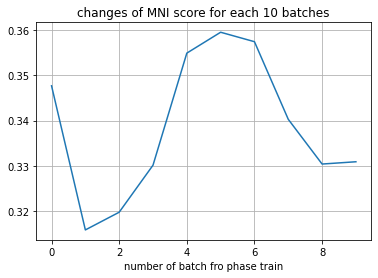

train Loss: 0.6429 Acc: 0.3381


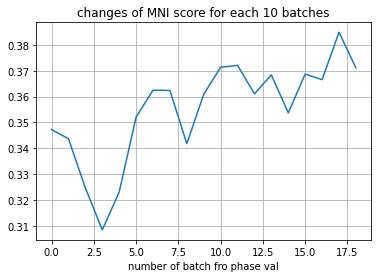

val Loss: 0.5184 Acc: 0.3678
new model


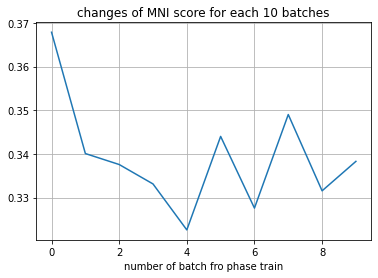

new model


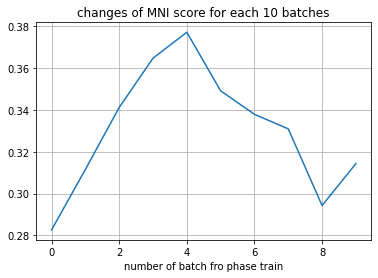

new model


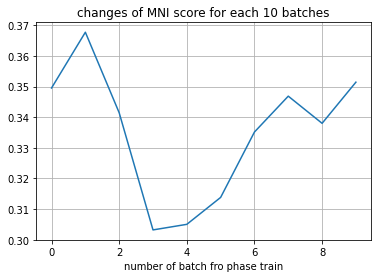

new model


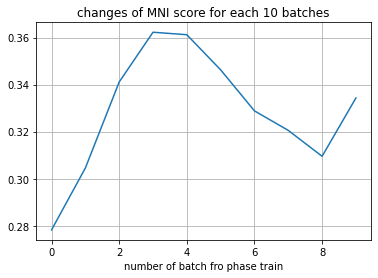

new model


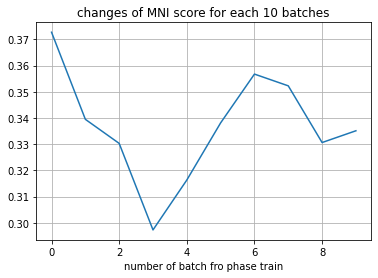

train Loss: 0.4787 Acc: 0.3336


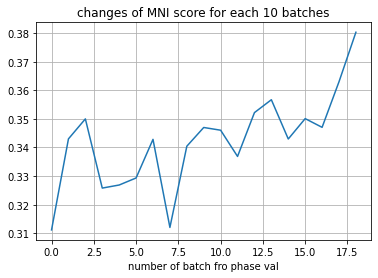

val Loss: 0.4140 Acc: 0.3515
new model


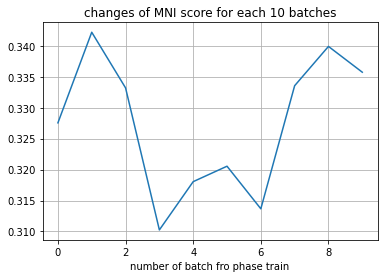

new model


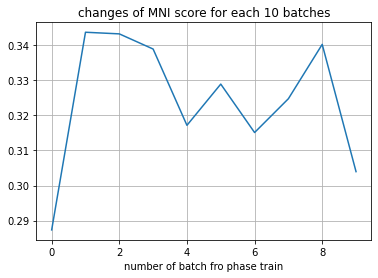

new model


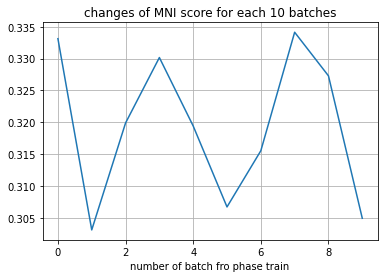

new model


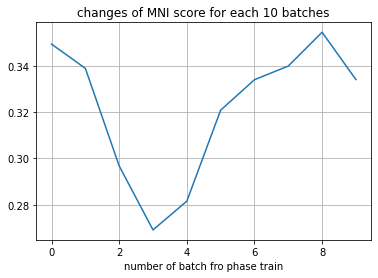

new model


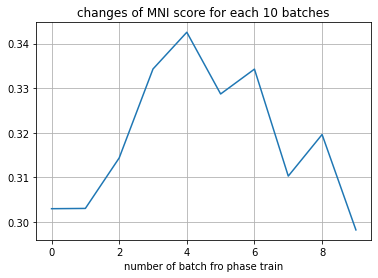

train Loss: 0.3844 Acc: 0.3224


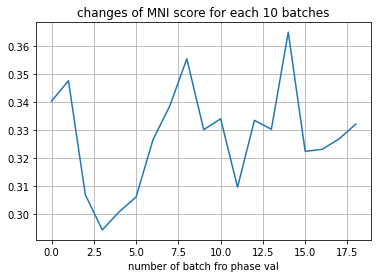

val Loss: 0.3409 Acc: 0.3307
new model


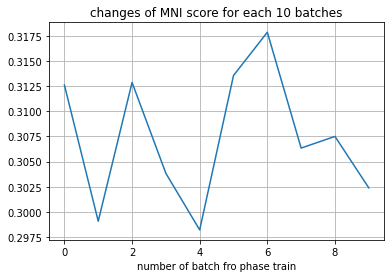

new model


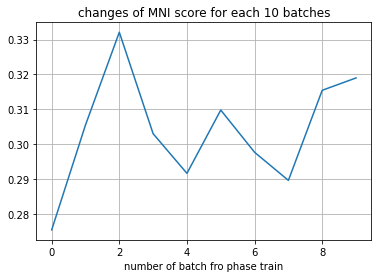

new model


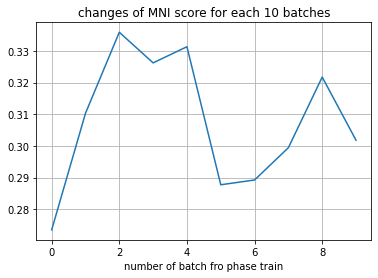

new model


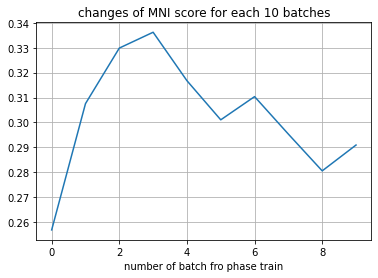

new model


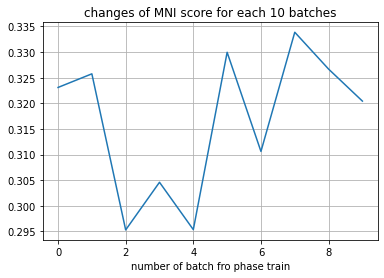

train Loss: 0.3376 Acc: 0.3071


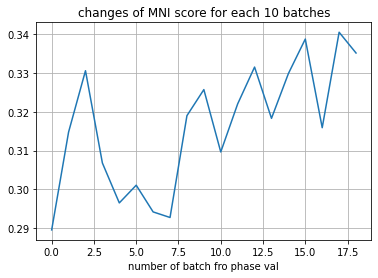

val Loss: 0.3439 Acc: 0.3265


In [98]:
model_drop = train_reconstructor(net_drop, criterion, optimizer, epoch = 6, lr=0.002)

Let's use the pretrained convolutional layers from deep clustering for transfer learing and compare the results with model, witch will not use the pretrained convolutional layers

In [99]:
def train_model_model(model, criterion, optimizer, epoch=25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_epoch_loss = 5
  best_acc = 0.0

  for i in range(epoch):
    corrects = []
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      if phase == 'val':
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          inputs = inputs.to(device)
          labels = labels.to(device)
          
          probs, vectors = model(inputs)
          _, preds = torch.max(probs, 1)
          
          loss = criterion(probs,labels)


          if (phase == 'train'):
              loss.backward()
              optimizer.step()

          corrects.append(torch.sum(preds == labels.data).double().to(cpu).detach().numpy() / inputs.size(0))

          

        running_loss += loss*inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      plt.plot(corrects)
      plt.xlabel(f'number of batch fro phase {phase}')
      plt.grid(True)
      plt.title(f'changes of accuracy score for phase {phase}')
      plt.show()
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

  model.load_state_dict(best_model_wts)
  return model

In [100]:
net2 = Net()
net2.conv1 = model_drop.conv1
for param in net2.parameters():
  param.requires_grad = False
net2.out = nn.Sequential(
            nn.Linear(32*7*7, 150),
            nn.Sigmoid(),
            nn.Linear(150, 10))
net2 = net2.to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(net2.parameters(), lr=0.001)

with pretrained frozen layers

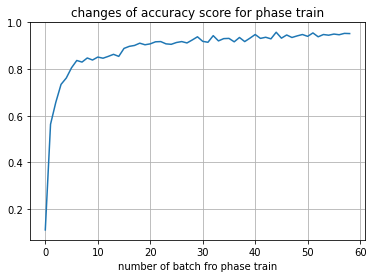

train Loss: 0.6126 Acc: 0.8831


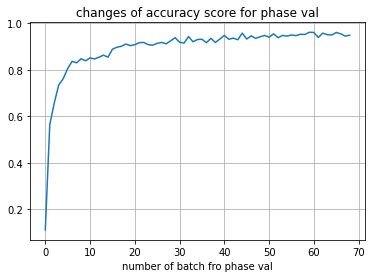

val Loss: 0.2245 Acc: 0.9533


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=150, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=150, out_features=10, bias=True)
  )
)

In [101]:
train_model_model(net2, criterion2, optimizer2, epoch=1)

simple training

In [102]:
net3 = Net()
net3 = net3.to(device)
# for param in net3.parameters():
#   param.requires_grad = False
# net3.out = nn.Sequential(
#             nn.Linear(32*7*7, 150),
#             nn.Sigmoid(),
#             nn.Linear(150, 10))
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(net3.parameters(), lr=0.0015)

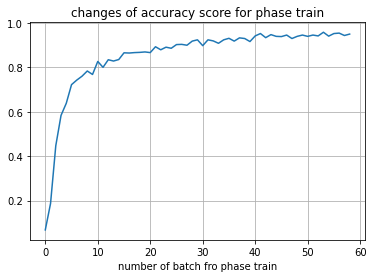

train Loss: 0.5547 Acc: 0.8519


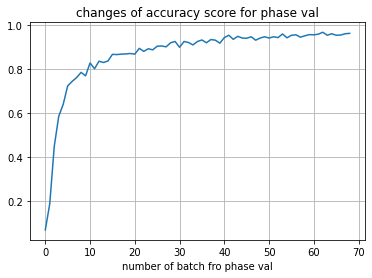

val Loss: 0.1475 Acc: 0.9577


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

In [103]:
train_model_model(net3, criterion3, optimizer3, epoch=1)

we can notice that the first version have increased learing seep in first steps, also we must not forget that in first version we trained only fully connected layers

Let's compare with model with frozen randomly initialized convolutional weights

In [106]:
net4 = Net()
for param in net4.parameters():
  param.requires_grad = False
net4.out = nn.Sequential(
            nn.Linear(32*7*7, 150),
            nn.Sigmoid(),
            nn.Linear(150, 10))
net4 = net4.to(device)
criterion4 = nn.CrossEntropyLoss()
optimizer4 = optim.Adam(net4.parameters(), lr=0.0015)

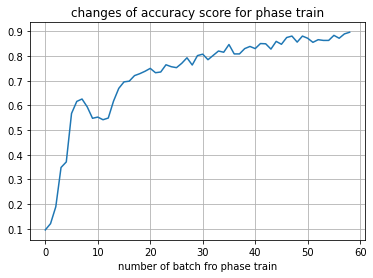

train Loss: 1.2552 Acc: 0.7241


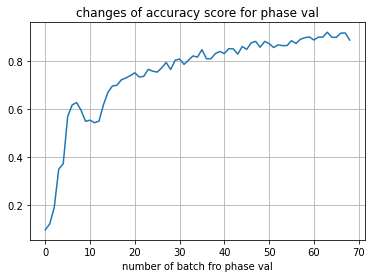

val Loss: 0.5413 Acc: 0.9019


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=150, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=150, out_features=10, bias=True)
  )
)

In [107]:
train_model_model(net4, criterion4, optimizer4, epoch=1)

for conclusion we can say, that the this type of deep clustering can reach not bad score without so mutch labels compared with classic learing. It could be used if the labeling process is pretty long, also this method is mutch better then the method with randomly initialized weights